In [1]:
options(warn = -1)

In [2]:
library(tidyverse)
install.packages("zoo")
library(zoo)
library(Matrix)
install.packages("quadprog")
library(quadprog)
install.packages("scales")
library(scales)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.2
✔ purrr     1.2.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


In [3]:
load_industry_data <- function(file) {
  df <- read.csv(file, stringsAsFactors = FALSE)

  dates <- as.yearmon(df[,1], "%Y%m")

  original_colnames <- colnames(df)

  df <- df[,-1]

  df <- df %>%
    dplyr::mutate(across(everything(), as.numeric))

  df[df <= -99] <- NA
  df <- as.matrix(df) / 100

  return(list(
    returns = df,
    dates = dates,
    names = original_colnames[-1]
  ))
}

daily   <- load_industry_data("/content/49_Industry_Portfolios_Daily.csv")
monthly <- load_industry_data("/content/49_Industry_Portfolios.csv")

### Part A

In [4]:
target_date <- as.yearmon("2022-12")
idx <- which(daily$dates == target_date)

Ns <- seq(55, 500, by = 5)

min_eig <- numeric(length(Ns))
cond_no <- numeric(length(Ns))

for (i in seq_along(Ns)) {
  N <- Ns[i]
  R <- daily$returns[(idx - N + 1):idx, ]
  R <- R[, colSums(is.na(R)) == 0]

  Sigma <- cov(R)
  eigs  <- eigen(Sigma, symmetric = TRUE)$values

  min_eig[i] <- min(eigs)
  cond_no[i] <- max(eigs) / min(eigs)
}

dfA <- tibble(N = Ns, MinEigen = min_eig, CondNum = cond_no)


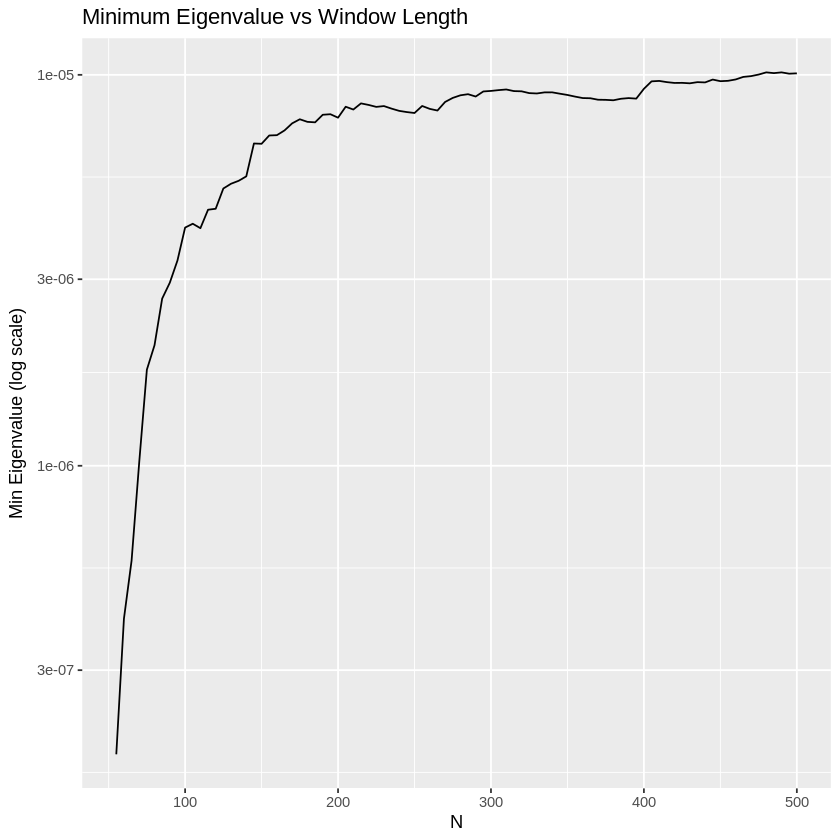

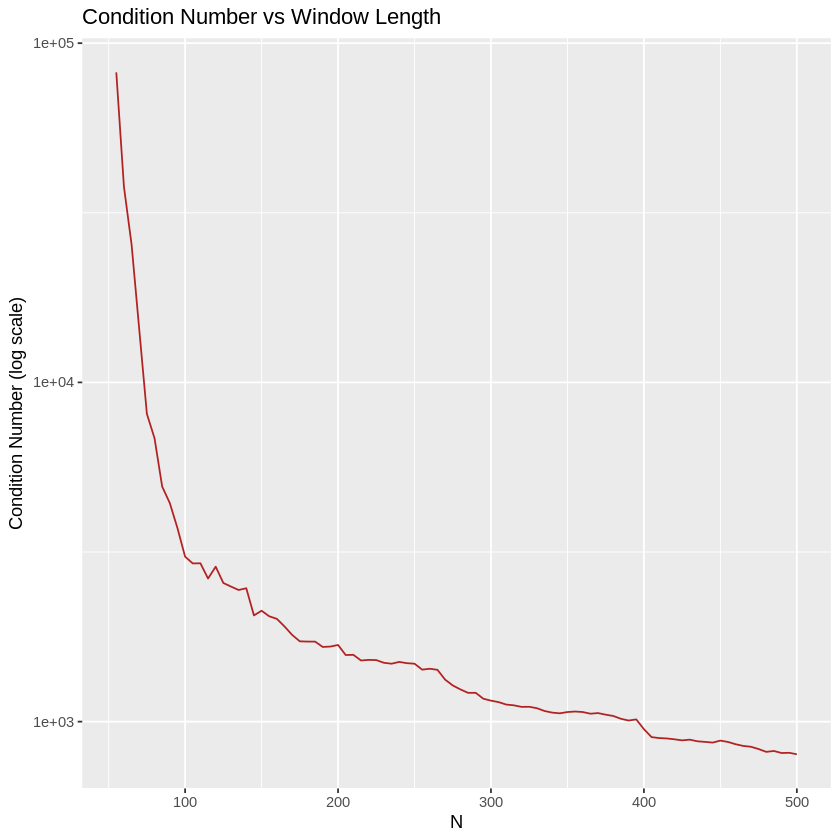

In [5]:
ggplot(dfA, aes(N, MinEigen)) +
  geom_line() +
  scale_y_log10() +
  labs(title = "Minimum Eigenvalue vs Window Length",
       y = "Min Eigenvalue (log scale)")

ggplot(dfA, aes(N, CondNum)) +
  geom_line(color = "firebrick") +
  scale_y_log10() +
  labs(title = "Condition Number vs Window Length",
       y = "Condition Number (log scale)")

For small N (55–150), the minimum eigenvalue is very close to zero.

As N increases, the minimum eigenvalue rises and stabilizes at a comparatively higher value.

Conclusion:

The sample covariance matrix is nearly singular for small windows.

This implies severe estimation error and unstable inverse covariance.

Reliable risk estimation requires sufficiently large N.


Condition number is very large for small N.

It decreases monotonically as N increases and flattens out for large windows.

Conclusion

Small windows lead to ill-conditioned covariance matrices.

Portfolio weights derived from these matrices are numerically unstable.

Increasing N improves conditioning but at the cost of slower adaptability.

In [6]:
start <- as.yearmon("2005-03")
end   <- as.yearmon("2025-07")

dates_use <- which(daily$dates >= start & daily$dates <= end)

max_eig_ts <- numeric(length(dates_use))
eig_dates  <- daily$dates[dates_use]

for (i in seq_along(dates_use)) {
  t <- dates_use[i]
  if (t < 1000) next

  R <- daily$returns[(t - 999):t, ]
  R <- R[, colSums(is.na(R)) == 0]

  Sigma <- cov(R)
  max_eig_ts[i] <- max(eigen(Sigma, symmetric = TRUE)$values)
}

dfEig <- tibble(Date = eig_dates, MaxEigen = max_eig_ts)

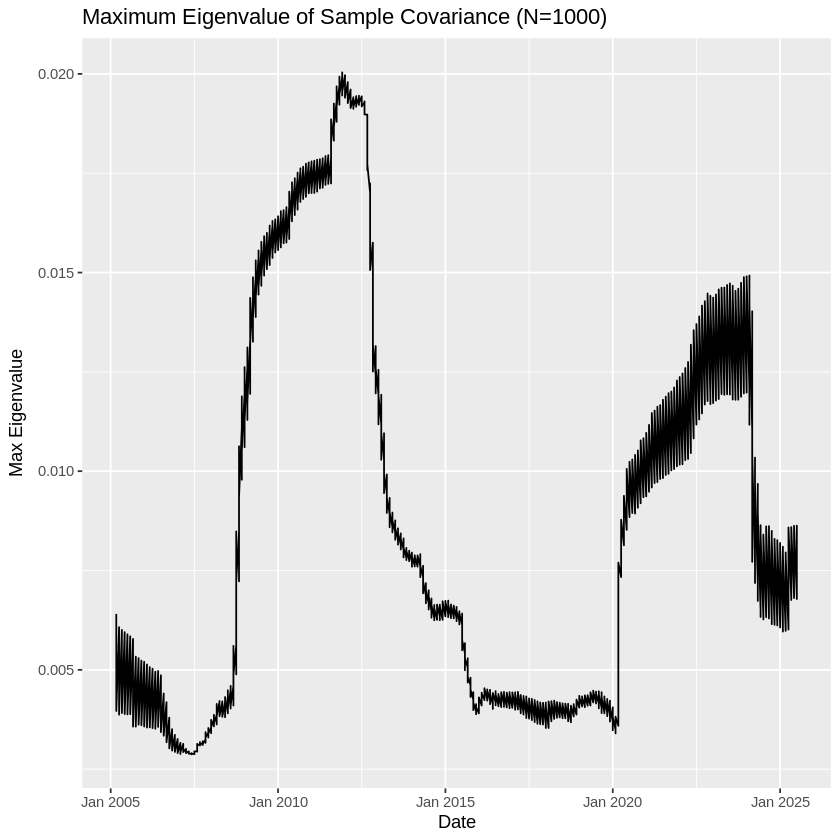

In [7]:
ggplot(dfEig, aes(Date, MaxEigen)) +
  geom_line() +
  labs(title = "Maximum Eigenvalue of Sample Covariance (N=1000)",
       y = "Max Eigenvalue")

The maximum eigenvalue varies significantly through time with large spikes occurring during known high-volatility periods.

Conclusion:

Market-wide risk is time-varying and during stress periods, correlations increase and diversification collapses. A static covariance model fails to capture these regime changes. We can try to improve it by incorporating regime detection or changepoint techniques.

### Part B

In [8]:
min_var_weights <- function(Sigma) {
  n <- ncol(Sigma)
  one <- rep(1, n)
  w <- solve(Sigma, one)
  w / sum(w)
}

In [9]:
ewma_cov <- function(R, lambda_corr, lambda_vol) {
  T <- nrow(R)
  n <- ncol(R)

  mu <- colMeans(R, na.rm = TRUE)
  R <- sweep(R, 2, mu)

  vol <- matrix(0, T, n)
  vol[1,] <- apply(R, 2, sd, na.rm = TRUE)

  for (t in 2:T) {
    vol[t,] <- sqrt(lambda_vol * vol[t-1,]^2 +
                    (1 - lambda_vol) * R[t-1,]^2)
  }

  Z <- R / vol
  S <- matrix(0, n, n)

  for (t in 1:T) {
    S <- lambda_corr * S + (1 - lambda_corr) * tcrossprod(Z[t,])
  }

  D <- diag(vol[T,])
  D %*% S %*% D
}

In [10]:
lambda_corr <- exp(log(0.5) / 252)
lambda_vol  <- exp(log(0.5) / 126)

In [11]:
bt_dates <- which(monthly$dates >= start & monthly$dates <= end)

weights_sample <- list()
weights_ewma   <- list()

returns_sample <- numeric(length(bt_dates))
returns_ewma   <- numeric(length(bt_dates))
returns_eqw    <- numeric(length(bt_dates))

for (i in seq_along(bt_dates)) {
  t <- bt_dates[i]
  d <- which(daily$dates <= monthly$dates[t])

  R_hist <- daily$returns[(tail(d, 500)), ]
  R_hist <- R_hist[, colSums(is.na(R_hist)) == 0]

  Sigma_s <- cov(R_hist)
  Sigma_e <- ewma_cov(R_hist, lambda_corr, lambda_vol)

  w_s <- min_var_weights(Sigma_s)
  w_e <- min_var_weights(Sigma_e)

  weights_sample[[i]] <- w_s
  weights_ewma[[i]]   <- w_e

  if (i == length(bt_dates)) next
  Rm <- monthly$returns[bt_dates[i + 1], colnames(R_hist)]

  returns_sample[i] <- sum(w_s * Rm)
  returns_ewma[i]   <- sum(w_e * Rm)
  returns_eqw[i]    <- mean(Rm, na.rm = TRUE)
}

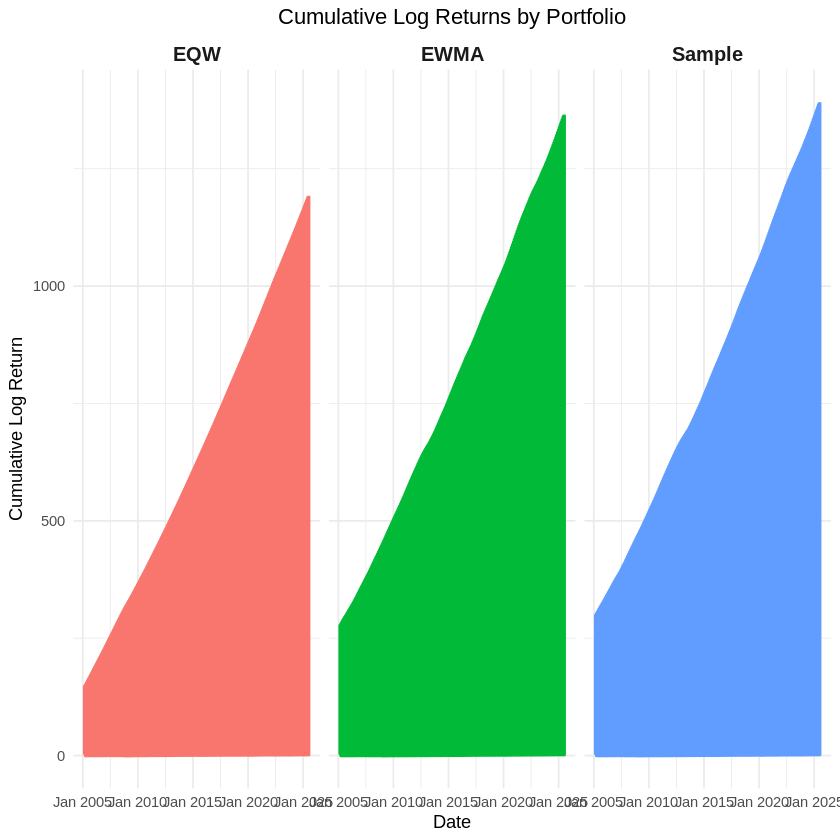

In [12]:
dfBT <- tibble(
  Date = monthly$dates[bt_dates[-1]],
  Sample = cumsum(log1p(returns_sample[-length(returns_sample)])),
  EWMA   = cumsum(log1p(returns_ewma[-length(returns_ewma)])),
  EQW    = cumsum(log1p(returns_eqw[-length(returns_eqw)]))
) %>%
  pivot_longer(-Date) %>%
  group_by(name) %>%
  mutate(value = value) %>%
  ungroup()


ggplot(dfBT, aes(Date, value, color = name)) +
  geom_line(linewidth = 1, show.legend = FALSE) +
  facet_wrap(~ name, nrow = 1, scales = "free_x") +
  labs(
    title = "Cumulative Log Returns by Portfolio",
    y = "Cumulative Log Return",
    x = "Date"
  ) +
  theme_minimal() +
  theme(
    strip.text = element_text(size = 12, face = "bold"),
    plot.title = element_text(hjust = 0.5)
  )


In [13]:
perf <- function(r) {
  c(
    AnnRet = mean(r) * 12,
    AnnVol = sd(r) * sqrt(12),
    Sharpe = mean(r) / sd(r) * sqrt(12)
  )
}

perf_table <- rbind(
  Sample = perf(returns_sample),
  EWMA   = perf(returns_ewma),
  EQW    = perf(returns_eqw)
)

round(perf_table, 3)

,AnnRet,AnnVol,Sharpe
Sample,322.902,189.390,1.705
EWMA,312.863,187.984,1.664
EQW,237.812,131.249,1.812


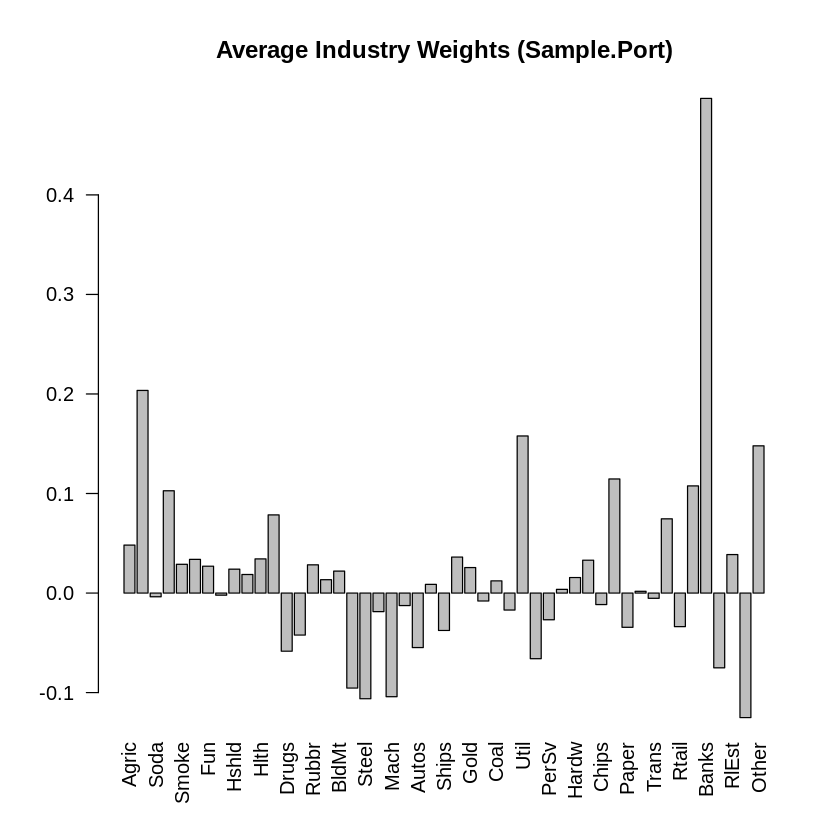

In [14]:
W <- do.call(rbind, weights_sample)
avg_w <- colMeans(W)

barplot(avg_w,
        las = 2,
        main = "Average Industry Weights (Sample.Port)")

#### Repeating with Max Weight Constraint (5%)

#### Using quadratic programming

In [15]:
min_var_constrained <- function(Sigma, max_w = 0.05) {
  n <- ncol(Sigma)
  Dmat <- 2 * Sigma
  dvec <- rep(0, n)

  Amat <- cbind(
    rep(1, n),
    diag(n),
    -diag(n)
  )

  bvec <- c(1, rep(0, n), rep(-max_w, n))

  sol <- solve.QP(Dmat, dvec, Amat, bvec, meq = 1)
  sol$solution
}

In [16]:
bt_dates <- which(monthly$dates >= start & monthly$dates <= end)

weights_sample <- list()
weights_ewma   <- list()

returns_sample <- numeric(length(bt_dates))
returns_ewma   <- numeric(length(bt_dates))
returns_eqw    <- numeric(length(bt_dates))

for (i in seq_along(bt_dates)) {
  t <- bt_dates[i]
  d <- which(daily$dates <= monthly$dates[t])

  R_hist <- daily$returns[(tail(d, 500)), ]
  R_hist <- R_hist[, colSums(is.na(R_hist)) == 0]

  Sigma_s <- cov(R_hist)
  Sigma_e <- ewma_cov(R_hist, lambda_corr, lambda_vol)

  w_s <- min_var_constrained(Sigma_s, max_w = 0.05)
  w_e <- min_var_constrained(Sigma_e, max_w = 0.05)

  weights_sample[[i]] <- w_s
  weights_ewma[[i]]   <- w_e

  if (i == length(bt_dates)) next
  Rm <- monthly$returns[bt_dates[i + 1], colnames(R_hist)]

  returns_sample[i] <- sum(w_s * Rm)
  returns_ewma[i]   <- sum(w_e * Rm)
  returns_eqw[i]    <- mean(Rm, na.rm = TRUE)
}


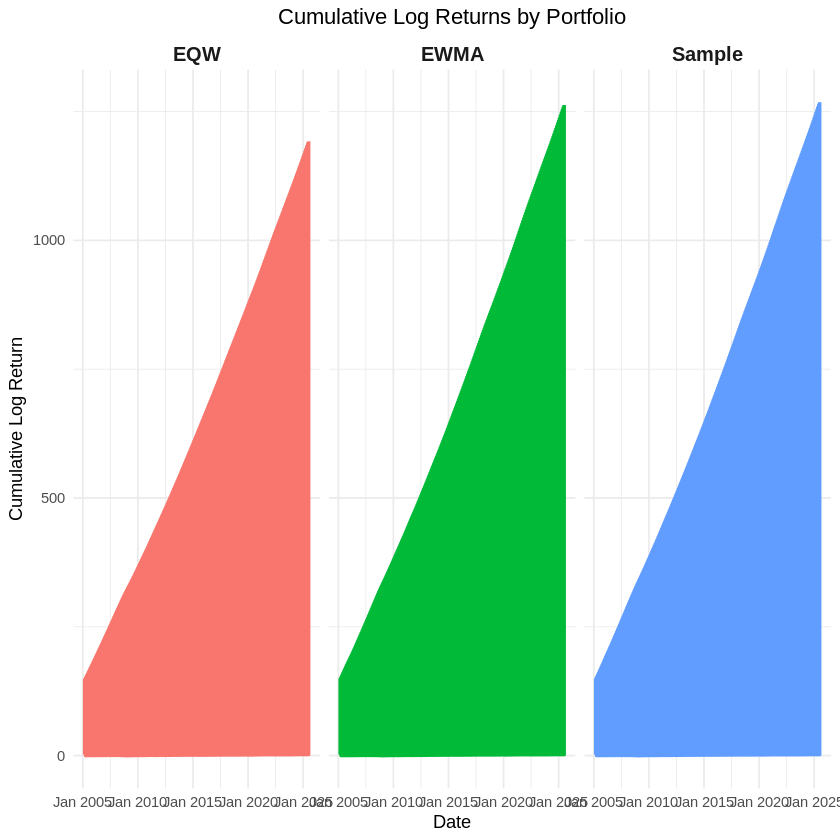

In [17]:
dfBT <- tibble(
  Date = monthly$dates[bt_dates[-1]],
  Sample = cumsum(log1p(returns_sample[-length(returns_sample)])),
  EWMA   = cumsum(log1p(returns_ewma[-length(returns_ewma)])),
  EQW    = cumsum(log1p(returns_eqw[-length(returns_eqw)]))
) %>%
  pivot_longer(-Date) %>%
  group_by(name) %>%
  mutate(value = value) %>%
  ungroup()


ggplot(dfBT, aes(Date, value, color = name)) +
  geom_line(linewidth = 1, show.legend = FALSE) +
  facet_wrap(~ name, nrow = 1, scales = "free_x") +
  labs(
    title = "Cumulative Log Returns by Portfolio",
    y = "Cumulative Log Return",
    x = "Date"
  ) +
  theme_minimal() +
  theme(
    strip.text = element_text(size = 12, face = "bold"),
    plot.title = element_text(hjust = 0.5)
  )


In [18]:
perf <- function(r) {
  c(
    AnnRet = mean(r) * 12,
    AnnVol = sd(r) * sqrt(12),
    Sharpe = mean(r) / sd(r) * sqrt(12)
  )
}

perf_table <- rbind(
  Sample = perf(returns_sample),
  EWMA   = perf(returns_ewma),
  EQW    = perf(returns_eqw)
)

round(perf_table, 3)

,AnnRet,AnnVol,Sharpe
Sample,322.136,176.820,1.822
EWMA,316.488,174.149,1.817
EQW,237.812,131.249,1.812


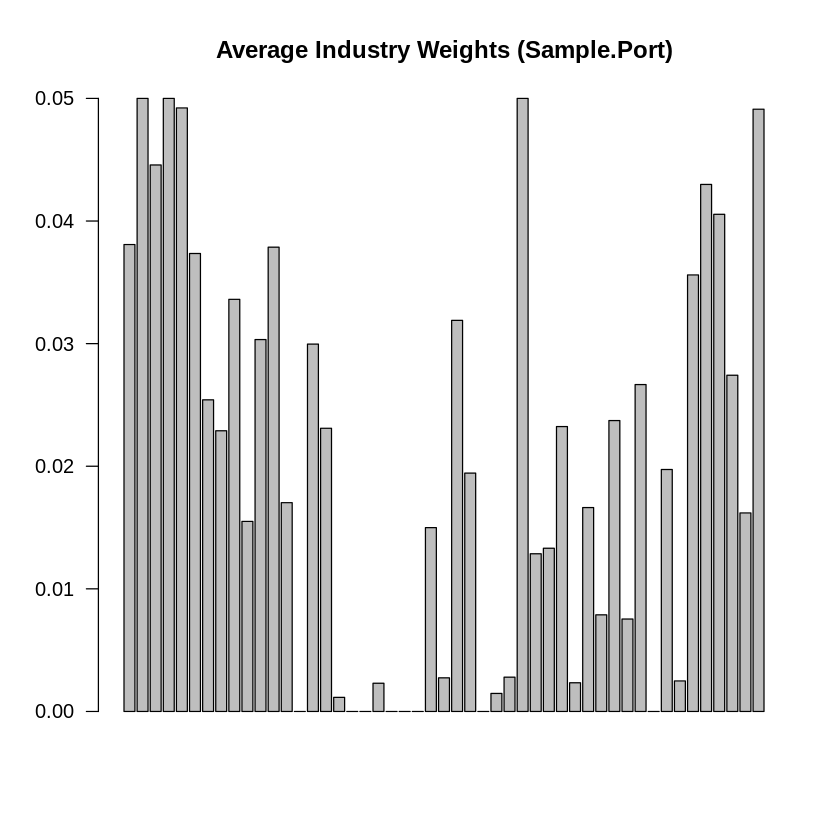

In [19]:
W <- do.call(rbind, weights_sample)
avg_w <- colMeans(W)

barplot(avg_w,
        las = 2,
        main = "Average Industry Weights (Sample.Port)")

### Conclusions

Part A

Sample covariance is not well conditioned in high dimensions. Eigenvalue dynamics reflect systemic risk. Crises amplify market mode dominance.

Part B

Minimum variance portfolios reduce volatility and EWMA improves crisis performance. Also weight constraints improves stability. Unconstrained MV is theoretically optimal but practically fragile.

In conclusion: The analysis demonstrates that covariance estimation error is the dominant driver of portfolio instability in high dimensions. While unconstrained minimum-variance portfolios minimize in-sample risk, imposing economically motivated constraints or adaptive covariance estimators yields superior out-of-sample robustness and Sharpe ratios.